In [128]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np
plt.rcParams.update({'font.size':12})

FILEDIR = '/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/'
vars = ['TMP2m', 'PRMSL']
seasons = ["DJF", "MAM", "SON", "JJA"]
var = vars[1]

# 20CRv3 background

In [132]:
tmp = xr.open_dataset(f'/home/ccorbella/scratch2_symboliclink/files/20CRv3_ensembles/ensmem.{var}.Europe/1806/{var}.1806_mem001_daymean_Europe.nc')
tmp2 = xr.open_dataset(f'/home/ccorbella/scratch2_symboliclink/files/20CRv3_ensembles/{var}.Europe.allmems/{var}.1806.Europe.allmems.nc')
tmp3 = xr.open_dataset(f'/home/ccorbella/scratch2_symboliclink/files/20CRv3_ensembles/{var}.Europe.allmems/{var}.Europe.allmems.allyears.nc')
# tmp4 = xr.open_dataset(f'/home/ccorbella/scratch2_symboliclink/files/20CRv3_ensembles/{var}.Europe.allmems/{var}.Europe.allmems.anomalies.nc')
tmp4 = xr.open_dataset(f'/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/data/{var}.Europe.allmems.anomalies.nc')

In [133]:
tmpA = tmp.isel(time=0)[var]
tmp2A = tmp2.isel(time=0,ensemble_member=0)[var]
tmp3A = tmp3.isel(time=0,ensemble_member=0)[var]
tmp4A = tmp3.isel(time=0,ensemble_member=0)[var]


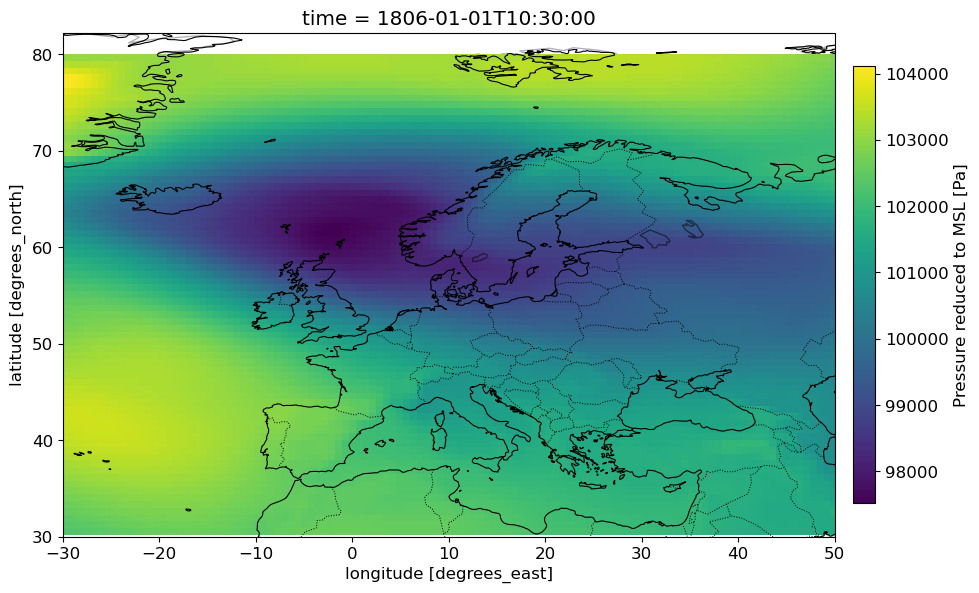

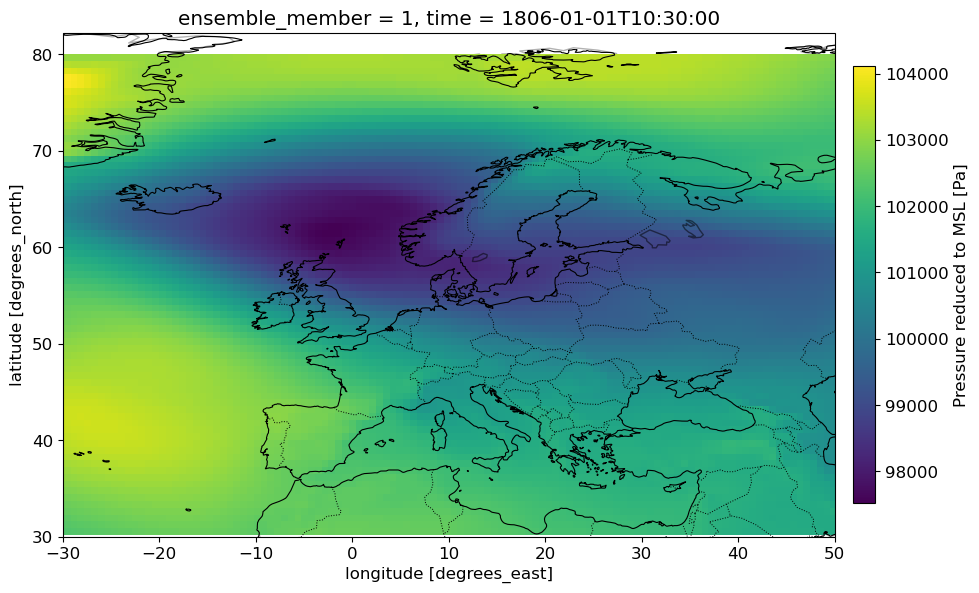

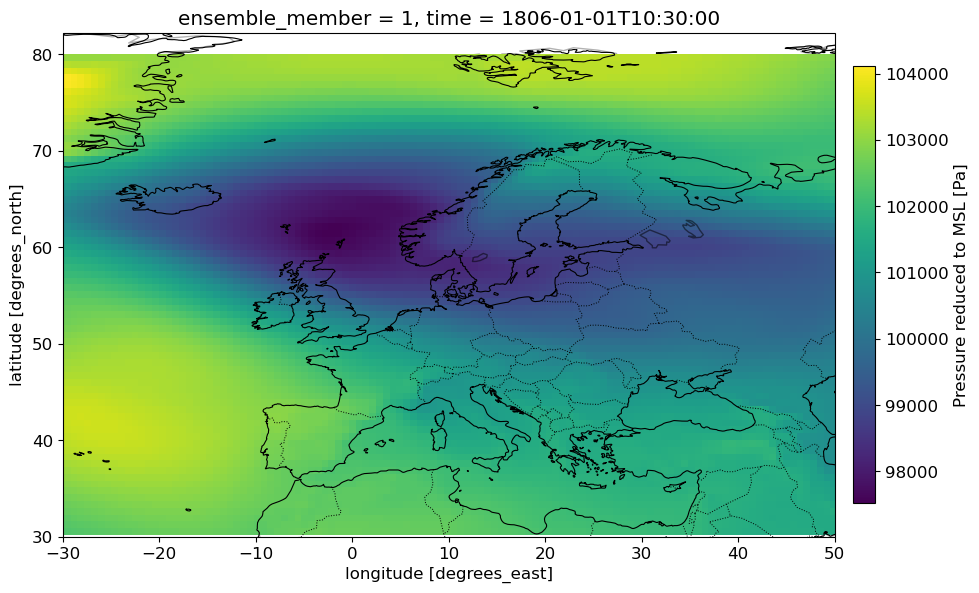

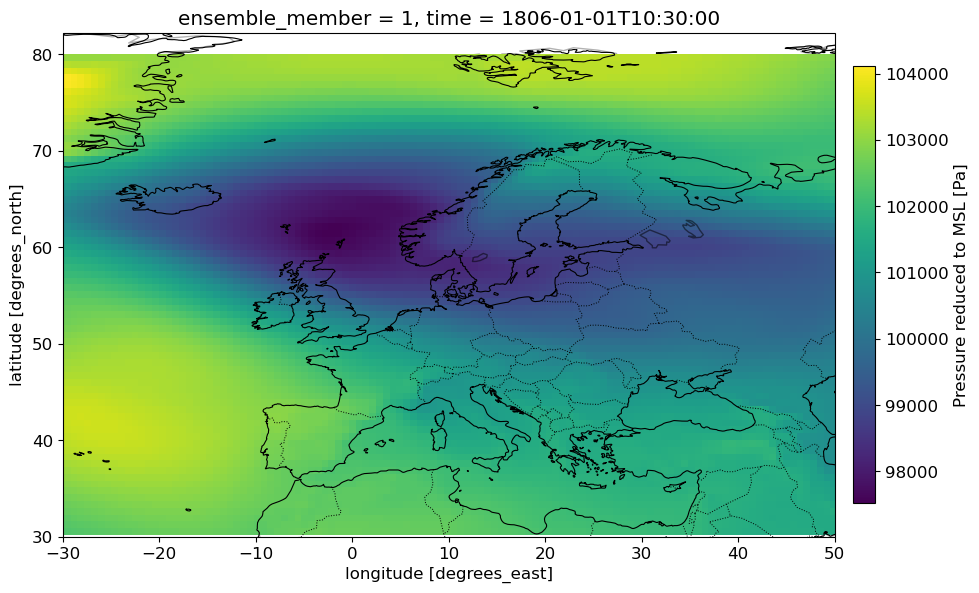

In [135]:
def plot_tmp(data):
    """Plot the spread data on a map."""
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Plot the data
    data.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={
            'pad': 0.02,
            'shrink': 0.71,
            'aspect': 20,
        }
    )
    ax.set_extent([-30, 50, 30, 80])
    ax.coastlines(resolution='50m', linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.7)
    ax.add_feature(cfeature.LAND, facecolor='none', edgecolor='black', alpha=0.3)
    ax.add_feature(cfeature.LAKES, facecolor='none', edgecolor='black', alpha=0.5)

    xticks = range(-30, 51, 10)  # Longitude ticks
    yticks = range(30, 81, 10)  # Latitude ticks
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())

    plt.show()

plot_tmp(tmpA)
plot_tmp(tmp2A)
plot_tmp(tmp3A)
plot_tmp(tmp4A)

# Observations

In [29]:
var = 'PRMSL'
p_obs_data = pd.read_csv('/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/data/p_obs_data.csv')
p_obs_data = p_obs_data.iloc[1:,:] # first row is stupid geworden

p_obs_anomals = pd.read_csv('/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/data/p_obs_anomalies.csv') # period 1806-1821

/tmp/ipykernel_1540430/188419747.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  p_obs_anomals_resampled = p_obs_anomals.set_index('Date').resample('M').mean().reset_index()


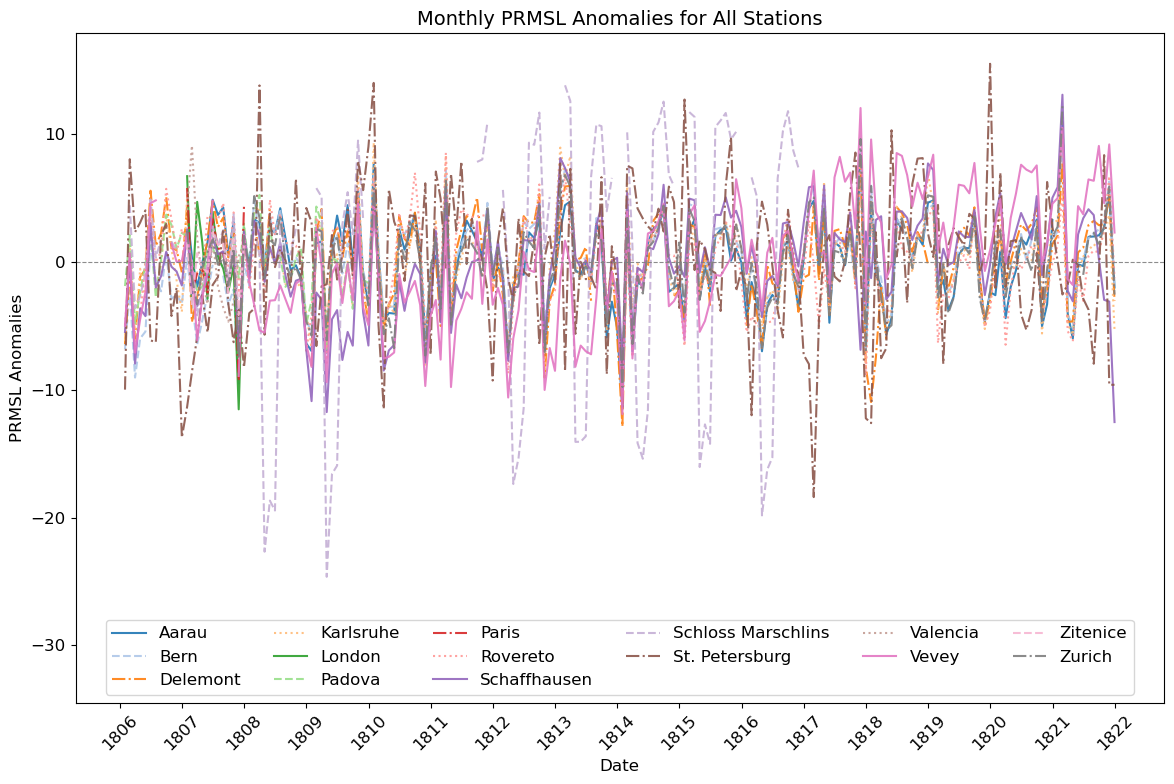

In [32]:
import matplotlib.dates as mdates


p_obs_anomals['Date'] = pd.to_datetime(p_obs_anomals['Date'])

# Resample or aggregate data (e.g., monthly mean)
p_monthly_means = p_obs_anomals.set_index('Date').resample('M').mean().reset_index()
#p_monthly_means = p_obs_anomals

# Set up the figure
plt.figure(figsize=(14, 8))
ax = plt.gca()

# Define color map and linestyles
colors = plt.cm.tab20(np.arange(len(p_monthly_means.columns[1:])))
linestyles = ['-', '--', '-.', ':']

# Plot each station
legend_entries = []
for i, station_name in enumerate(p_monthly_means.columns[1:]):
    color = colors[i]  # Cycle through colors
    linestyle = linestyles[i % len(linestyles)]  # Cycle through linestyles
    
    ax.plot(
        p_monthly_means['Date'], 
        p_monthly_means[station_name], 
        label=station_name, 
        color=color, 
        linestyle=linestyle, 
        alpha=0.9
    )
    
    # # Count values above and below zero
    # gt_zero = np.sum(p_obs_anomals[station_name] > 0)
    # lt_zero = np.sum(p_obs_anomals[station_name] < 0)
    # gt_zero_perc = gt_zero / (gt_zero + lt_zero) * 100
    # lt_zero_perc = lt_zero / (gt_zero + lt_zero) * 100
    
    # # Prepare legend entry
    # legend_entries.append(f"{station_name}: >0: {gt_zero} ({gt_zero_perc:.1f}%), <0: {lt_zero} ({lt_zero_perc:.1f}%)")

# Add a horizontal line at 0
ax.axhline(0, color='gray', linestyle='dashed', linewidth=0.8, alpha=0.9)

# Adjust x-axis ticks and format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

# Add legend
ax.legend(loc='lower center', ncol=6, fontsize=12)

# Add a text box with details for all stations
text_box = '\n'.join(legend_entries)
props = dict(boxstyle='round', facecolor='white')
ax.text(1.05, 0.5, text_box, transform=ax.transAxes, fontsize=9, 
        verticalalignment='center', bbox=props)

# Customize axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel(f'{var} Anomalies')
ax.set_title(f'Monthly {var} Anomalies for All Stations', fontsize=14)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave room for text box
plt.savefig(f'/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/output/{var}_obs_anomalies.png')
plt.show()


In [97]:
var = 'TMP2m'
t_obs_anomalies = pd.read_csv('/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/data/TMP2m_obs_anomalies.txt', 
                              delim_whitespace=True, header=None)

t_obs_anomalies["Date"] = pd.to_datetime(p_obs_anomals["Date"])
t_obs_anomalies.set_index('Date', inplace=True)
t_monthly_means = t_obs_anomalies.resample('M').mean().reset_index()

t_obs_metadata = pd.read_csv('/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/data/TMP2m_obs_metadata.csv')

# remove IMPROVE St Petersburg station as I didn't assimilate it
t_obs_metadata = t_obs_metadata[t_obs_metadata['station'] != 'IMPROVE_StPetersburg']

/tmp/ipykernel_1540430/3188350768.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  t_obs_anomalies = pd.read_csv('/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/data/TMP2m_obs_anomalies.txt',
/tmp/ipykernel_1540430/3188350768.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  t_monthly_means = t_obs_anomalies.resample('M').mean().reset_index()


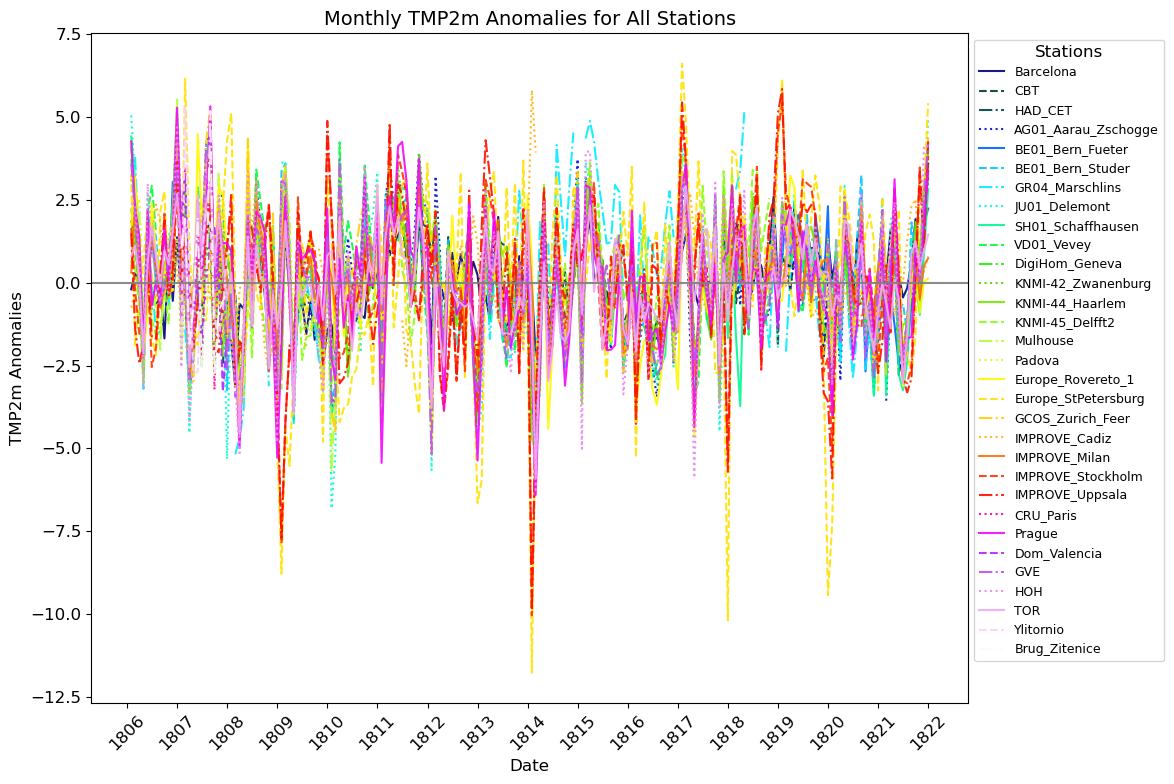

In [121]:
plt.figure(figsize=(14, 8))
ax = plt.gca()

# Define color map and linestyles
colors = plt.cm.gist_ncar(np.linspace(0,1, t_obs_metadata.shape[0]))
linestyles = ['-', '--', '-.', ':']

# Plot each station
for i, station_name in enumerate(t_obs_metadata['station']):
    linestyle = linestyles[i % len(linestyles)]  # Cycle through linestyles
    
    ax.plot(
        t_monthly_means['Date'], 
        t_monthly_means[i], 
        label=station_name, 
        color=colors[i], 
        linestyle=linestyle, 
        alpha=0.9
    )

# Add a horizontal line at 0
plt.legend(
    loc='upper left',         # Anchor the legend in the upper left corner
    bbox_to_anchor=(1, 1),    # Position the legend outside the plot area
    title="Stations",         # Add a title to the legend
    fontsize=9                # Adjust font size for better readability
)

ax.axhline(0, linestyle='-', color='gray', alpha=0.9)

# Adjust x-axis ticks and format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

# Add a text box with details for all stations
text_box = '\n'.join(legend_entries)
props = dict(boxstyle='round', facecolor='white')
ax.text(1.05, 0.5, text_box, transform=ax.transAxes, fontsize=9, 
        verticalalignment='center', bbox=props)

# Customize axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel(f'{var} Anomalies')
ax.set_title(f'Monthly {var} Anomalies for All Stations', fontsize=14)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave room for text box
plt.savefig(f'/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/output/{var}_obs_anomalies.png')
plt.show()